In [448]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay,classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, recall_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


In [449]:
df = pd.read_csv("/content/drive/MyDrive/Data_driven/data/bank-additional-full.csv", sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Visual

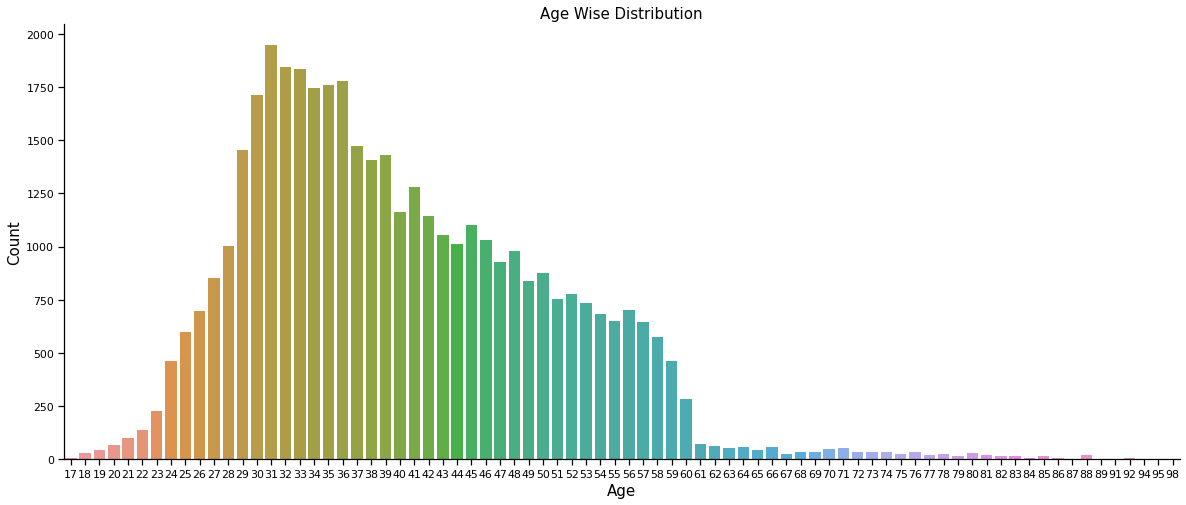

In [450]:
# Checking the distribution of Age
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'age', data = df)
ax.set_xlabel('Age', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Age Wise Distribution', fontsize=15)
sns.despine()

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


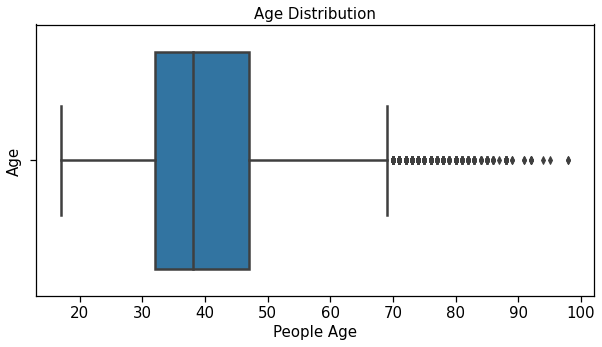

In [451]:
# Checking the outliers in Age
fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 5))
sns.boxplot(x = 'age', data = df, orient = 'v', ax = ax1)
ax1.set_xlabel('People Age', fontsize=15)
ax1.set_ylabel('Age', fontsize=15)
ax1.set_title('Age Distribution', fontsize=15)
ax1.tick_params(labelsize=15)

In [452]:
# Calculate the outliers
Q1=df['age'].quantile(q = 0.25)
Q2=df['age'].quantile(q = 0.50)
Q3=df['age'].quantile(q = 0.75)
Q4=df['age'].quantile(q = 1.00)                        
IQR= Q3-Q1
print('1st Quartile: ', Q1)
print('2nd Quartile: ', Q2)
print('3rd Quartile: ', Q3)
print('4th Quartile: ', Q4)
print('IQR: ',IQR)

print('Ages above: ', Q3 + 1.5*(IQR), 'are outliers')
print('Ages below: ', Q1 - 1.5*(IQR), 'are outliers')


1st Quartile:  32.0
2nd Quartile:  38.0
3rd Quartile:  47.0
4th Quartile:  98.0
IQR:  15.0
Ages above:  69.5 are outliers
Ages below:  9.5 are outliers


Chia nhóm Age để giảm outliner

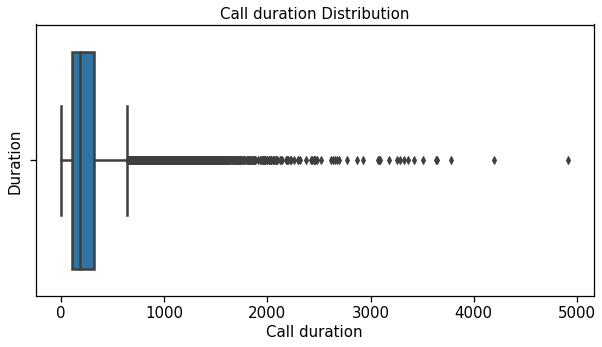

In [453]:
# checking the duration column

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 5))
sns.boxplot(x = 'duration', data = df, orient = 'h', ax = ax1)
ax1.set_xlabel('Call duration', fontsize=15)
ax1.set_ylabel('Duration', fontsize=15)
ax1.set_title('Call duration Distribution', fontsize=15)
ax1.tick_params(labelsize=15)

Chia nhóm duration để giảm outliner

In [454]:
index_df = df[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx','euribor3m','nr.employed']]
index_df.head()

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.1,93.994,-36.4,4.857,5191.0
1,1.1,93.994,-36.4,4.857,5191.0
2,1.1,93.994,-36.4,4.857,5191.0
3,1.1,93.994,-36.4,4.857,5191.0
4,1.1,93.994,-36.4,4.857,5191.0


In [455]:
idx_corr=index_df.corr()

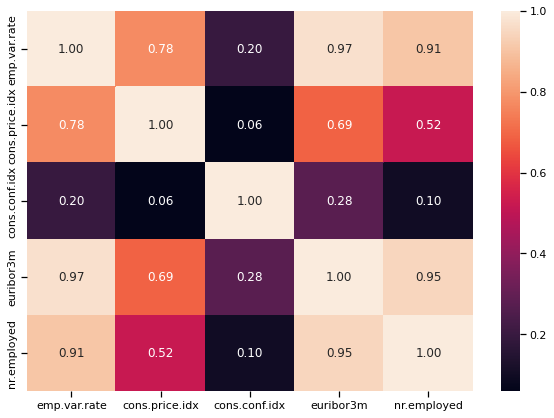

In [456]:
sns.set_context("notebook",font_scale = 1.0, rc = {"lines.linewidth":2.5})
plt.figure(figsize = (10,7))
a = sns.heatmap(idx_corr, annot = True, fmt = ".2f")

euribor3m variable is highly correlated with 3 variables such as emp.var.rate, cons.price.idx & nr.employed variables so we can straight away remove these variables

## processing

In [457]:
def clean(df):
  df.dropna(inplace=True)
  df = df.drop(columns=['emp.var.rate','cons.price.idx', 'nr.employed'])
  return df

def fill_na():
  num_types = ['float64', 'float32', 'int8', 'int16', 'int32', 'int64', 'bool']
  num_cols = [col for col in df.columns if df[col].dtypes in num_types]
  cat_cols = [col for col in df.columns if df[col].dtypes == 'object']
  df[num_cols] = df[num_cols].fill_na(0)
  df[cat_cols] = df[cat_cols].fill_na('missing')
  return df

def age(df):
    df.loc[df['age'] <= 32, 'age'] = 1
    df.loc[(df['age'] > 32) & (df['age'] <= 47), 'age'] = 2
    df.loc[(df['age'] > 47) & (df['age'] <= 70), 'age'] = 3
    df.loc[(df['age'] > 70), 'age']=4
    return df
           
def duration(df):
    df.loc[df['duration'] <= 102, 'duration'] = 1
    df.loc[(df['duration'] > 102) & (df['duration'] <= 180)  , 'duration']    = 2
    df.loc[(df['duration'] > 180) & (df['duration'] <= 319)  , 'duration']   = 3
    df.loc[(df['duration'] > 319) & (df['duration'] <= 644.5), 'duration'] = 4
    df.loc[df['duration']  > 644.5, 'duration'] = 5
    return df

def week_month(df):
  d_week = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5, 
    'sat':6, 'sun':7}
  d_mons = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 
    'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10,
    'nov':11, 'dec':12}
  df.month = df.month.map(d_mons)
  df.day_of_week = df.day_of_week.map(d_week)
  return df

def Encoder(df):
  le = LabelEncoder()
  df = pd.get_dummies(df, columns = ['job'])
  df = pd.get_dummies(df, columns = ['marital'])
  df = pd.get_dummies(df, columns = ['education'])
  df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
  df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
  df.default = df.default.map({'no':0,'yes':1,'unknown':0})
  df['contact'] = df['contact'].map({'telephone': 1, 'cellular': 0})
  df['poutcome'] = df['poutcome'].map({'success': 1, 'nonexistent': 0, 'failure':0})
  df['y'] = df['y'].replace({'yes':1, 'no':0})
  return df

In [458]:
df = clean(df)
df = age(df)
df = duration(df)
df = week_month(df)
df = Encoder(df)
df.head()

,age,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons.conf.idx,euribor3m,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown
0,3,0,0.0,0.0,1,5,1,3,1,999,0,0,-36.4,4.857,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,3,0,0.0,0.0,1,5,1,2,1,999,0,0,-36.4,4.857,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,2,0,1.0,0.0,1,5,1,3,1,999,0,0,-36.4,4.857,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,2,0,0.0,0.0,1,5,1,2,1,999,0,0,-36.4,4.857,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
4,3,0,0.0,1.0,1,5,1,3,1,999,0,0,-36.4,4.857,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


## Train-test

In [459]:
df = df.dropna()

In [460]:
X = df.loc[:, df.columns != 'y']
Y = df.loc[:, df.columns == 'y']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
columns = X_train.columns


### Imbalance

In [461]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=42)
os_data_X,os_data_y=smt.fit_resample(X_train, y_train)

In [462]:
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  49972
Number of no subscription in oversampled data 24986
Number of subscription 24986
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [463]:
X=os_data_X
Y=os_data_y
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
columns = X_train.columns

### Model selection

In [464]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))

In [465]:
results = []
names = []

for name, model in models:
    # define how to split off validation data ('kfold' how many folds)
    kfold = KFold(n_splits=10)    
    # train the model
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')    
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

LR: 0.846284 (0.009224)
CART: 0.920097 (0.004388)


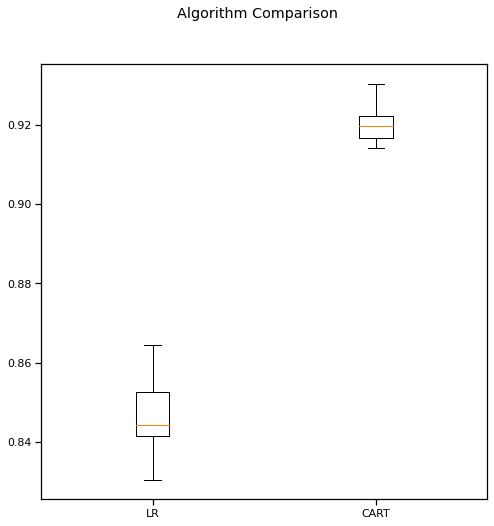

In [466]:
fig = plt.figure(figsize=(8, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [468]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, y_train) * 100, 2)
print(round(acc_log,2,), "%")

cm_lr = confusion_matrix(y_test, y_pred)
print("Report", classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


83.93 %
Report               precision    recall  f1-score   support

           0       0.85      0.83      0.84      7520
           1       0.84      0.85      0.84      7472

    accuracy                           0.84     14992
   macro avg       0.84      0.84      0.84     14992
weighted avg       0.84      0.84      0.84     14992



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [469]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
print(round(acc_decision_tree,2,), "%")

cm_dt = confusion_matrix(y_test, y_pred)
print("Report", classification_report(y_test, y_pred))

99.89 %
Report               precision    recall  f1-score   support

           0       0.94      0.91      0.92      7520
           1       0.91      0.94      0.93      7472

    accuracy                           0.93     14992
   macro avg       0.93      0.93      0.93     14992
weighted avg       0.93      0.93      0.93     14992



In [434]:
classifiers = [
               LogisticRegression(),
               DecisionTreeClassifier()
               ]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr1','tpr1','fpr','tpr','train_accuracy','test_accuracy', 'train_auc', 'test_auc', 'f1_score', 'precision','recall','confusion matrix','Report'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_accuracy= accuracy_score(y_train, y_train_pred)
    test_accuracy= accuracy_score(y_test, y_test_pred)
     
    fpr, tpr, _ = roc_curve(y_test,  y_test_pred)
    fpr1, tpr1, _ = roc_curve(y_train,  y_train_pred)
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    
    f1_score= metrics.f1_score(y_test, y_test_pred)
    precision = metrics.precision_score(y_test, y_test_pred)
    recall = metrics.recall_score(y_test, y_test_pred)
    
    conf_mat= confusion_matrix(y_test,y_test_pred)
    report=classification_report(y_test,y_test_pred, digits=3, output_dict=True)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr1':fpr1,
                                        'tpr1':tpr1,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'train_accuracy': train_accuracy,
                                        'test_accuracy': test_accuracy,
                                        'train_auc':train_auc,
                                        'test_auc':test_auc,
                                        'f1_score': f1_score,
                                        'precision': precision,
                                        'recall': recall,
                                        'confusion matrix':conf_mat,
                                        'Report':report}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [435]:
result_table.rename(index={'VotingClassifier':'Model Ensemble'},inplace=True)
result_table

,fpr1,tpr1,fpr,tpr,train_accuracy,test_accuracy,train_auc,test_auc,f1_score,precision,recall,confusion matrix,Report
classifiers,,,,,,,,,,,,,
LogisticRegression,"[0.0, 0.17330814153211954, 1.0]","[0.0, 0.8518328194587187, 1.0]","[0.0, 0.1658244680851064, 1.0]","[0.0, 0.853051391862955, 1.0]",0.839280,0.843583,0.839262,0.843613,0.844630,0.836373,0.853051,"[[6273, 1247], [1098, 6374]]","{'0': {'precision': 0.851037851037851, 'recall..."
DecisionTreeClassifier,"[0.0, 0.0004580327493415779, 1.0]","[0.0, 0.9982299874386206, 1.0]","[0.0, 0.08550531914893617, 1.0]","[0.0, 0.9383029978586723, 1.0]",0.998885,0.926361,0.998886,0.926399,0.927013,0.915992,0.938303,"[[6877, 643], [461, 7011]]","{'0': {'precision': 0.9371763423276097, 'recal..."


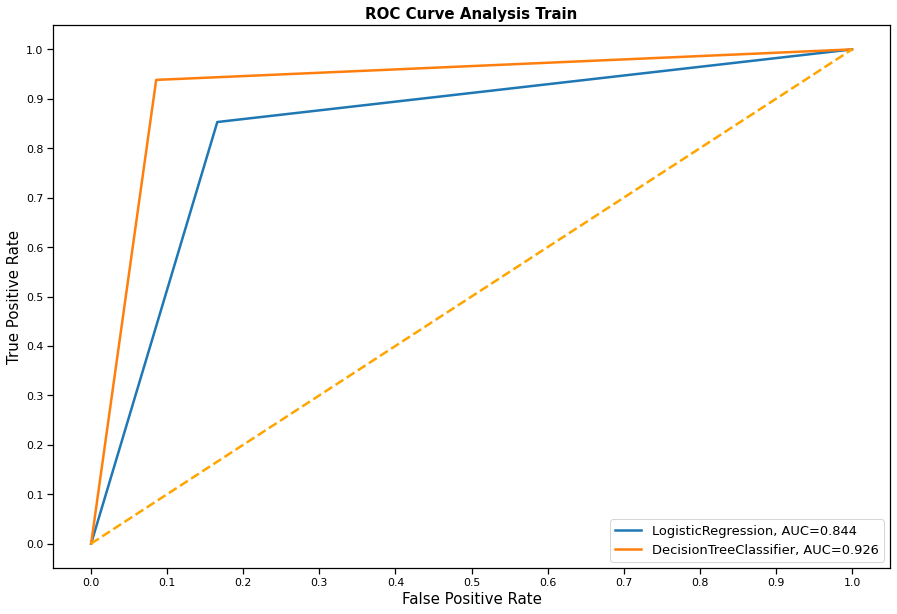

In [436]:
fig = plt.figure(figsize=(15,10))

for i in range(result_table.shape[0]):
    plt.plot(result_table.iloc[i,]['fpr'], 
             result_table.iloc[i,]['tpr'], 
             label="{}, AUC={:.3f}".format(result_table.index[i], result_table.iloc[i,]['test_auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('ROC Curve Analysis Train', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()

Use DecisionTreeClassifier